# Sales Prediction Using Advertising Data

This notebook takes a look at how different machine learning models can predict sales based on how much is spent on advertising across various channels. I’ve used the advertising dataset to see which regression models perform best for this kind of prediction.

The main idea is to estimate sales using the advertising budgets for TV, Radio, and Newspaper.

## Import Libraries

Let's start by importing all the necessary libraries for data manipulation, visualization, and modeling.

In [21]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
from sklearn.linear_model import LinearRegression, Ridge, Lasso
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.svm import SVR
sns.set_style('whitegrid')
plt.rcParams['figure.figsize'] = (10, 6)

import warnings
warnings.filterwarnings('ignore')

## Load and Explore the Data

First, let's load the advertising dataset and look at what we're working with.

In [22]:
df = pd.read_csv('Advertising.csv')
df = df.drop('Unnamed: 0', axis=1)
print("Dataset shape:", df.shape)
print("\nFirst few rows:")
df.head()

Dataset shape: (200, 4)

First few rows:


,TV,Radio,Newspaper,Sales
0,230.1,37.8,69.2,22.1
1,44.5,39.3,45.1,10.4
2,17.2,45.9,69.3,9.3
3,151.5,41.3,58.5,18.5
4,180.8,10.8,58.4,12.9


In [3]:
print("Missing values:\n", df.isnull().sum())
print("\nData types:\n", df.dtypes)
print("\nBasic statistics:")
df.describe()

Missing values:
 Unnamed: 0    0
TV            0
Radio         0
Newspaper     0
Sales         0
dtype: int64

Data types:
 Unnamed: 0      int64
TV            float64
Radio         float64
Newspaper     float64
Sales         float64
dtype: object

Basic statistics:


,Unnamed: 0,TV,Radio,Newspaper,Sales
count,200.000000,200.000000,200.000000,200.000000,200.000000
mean,100.500000,147.042500,23.264000,30.554000,14.022500
std,57.879185,85.854236,14.846809,21.778621,5.217457
min,1.000000,0.700000,0.000000,0.300000,1.600000
25%,50.750000,74.375000,9.975000,12.750000,10.375000
50%,100.500000,149.750000,22.900000,25.750000,12.900000
75%,150.250000,218.825000,36.525000,45.100000,17.400000
max,200.000000,296.400000,49.600000,114.000000,27.000000


In [4]:
print("Dataset Information:")
df.info()

Dataset Information:
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 200 entries, 0 to 199
Data columns (total 5 columns):
 #   Column      Non-Null Count  Dtype  
---  ------      --------------  -----  
 0   Unnamed: 0  200 non-null    int64  
 1   TV          200 non-null    float64
 2   Radio       200 non-null    float64
 3   Newspaper   200 non-null    float64
 4   Sales       200 non-null    float64
dtypes: float64(4), int64(1)
memory usage: 7.9 KB


## Exploratory Data Analysis (EDA)

Let's visualize the relationships between advertising channels and sales to better understand our data.

In [5]:
if df.columns[0] == 'Unnamed: 0' or df.iloc[:, 0].dtype == 'int64' and df.iloc[0, 0] == 1:
    df = df.iloc[:, 1:]
    print("Removed index column")
print("\nDataset columns:", df.columns.tolist())
print("Dataset shape:", df.shape)

Removed index column

Dataset columns: ['TV', 'Radio', 'Newspaper', 'Sales']
Dataset shape: (200, 4)


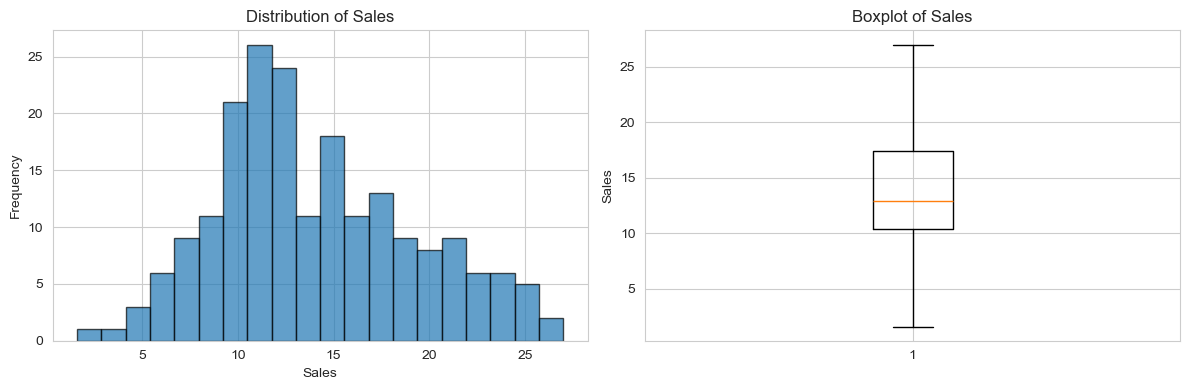

In [6]:
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.hist(df['Sales'], bins=20, edgecolor='black', alpha=0.7)
plt.xlabel('Sales')
plt.ylabel('Frequency')
plt.title('Distribution of Sales')

plt.subplot(1, 2, 2)
plt.boxplot(df['Sales'])
plt.ylabel('Sales')
plt.title('Boxplot of Sales')

plt.tight_layout()
plt.show()

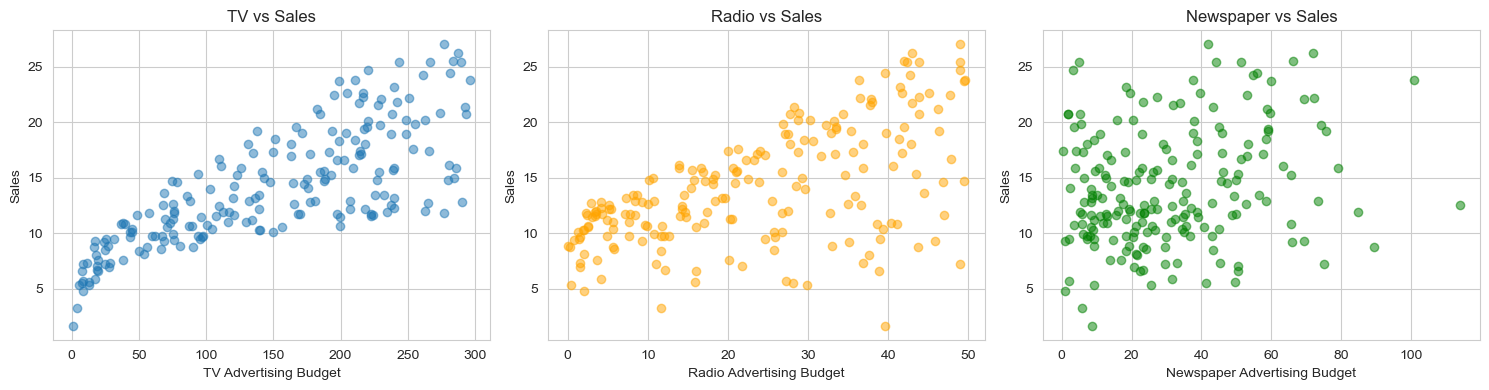

In [7]:
fig, axes = plt.subplots(1, 3, figsize=(15, 4))

axes[0].scatter(df['TV'], df['Sales'], alpha=0.5)
axes[0].set_xlabel('TV Advertising Budget')
axes[0].set_ylabel('Sales')
axes[0].set_title('TV vs Sales')

axes[1].scatter(df['Radio'], df['Sales'], alpha=0.5, color='orange')
axes[1].set_xlabel('Radio Advertising Budget')
axes[1].set_ylabel('Sales')
axes[1].set_title('Radio vs Sales')

axes[2].scatter(df['Newspaper'], df['Sales'], alpha=0.5, color='green')
axes[2].set_xlabel('Newspaper Advertising Budget')
axes[2].set_ylabel('Sales')
axes[2].set_title('Newspaper vs Sales')

plt.tight_layout()
plt.show()

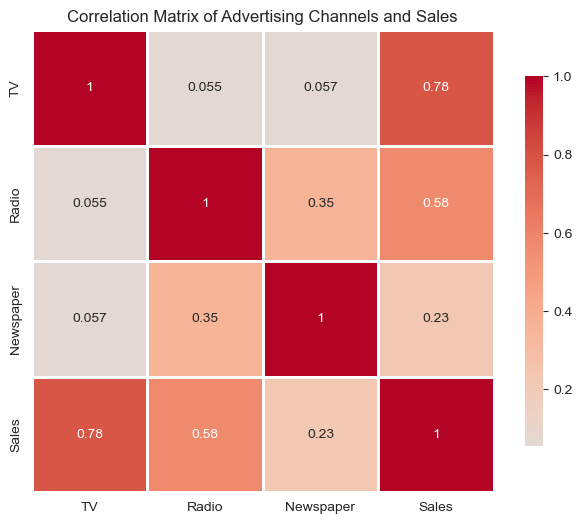


Correlation with Sales:
Sales        1.000000
TV           0.782224
Radio        0.576223
Newspaper    0.228299
Name: Sales, dtype: float64


In [8]:
plt.figure(figsize=(8, 6))
correlation_matrix = df.corr()
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix of Advertising Channels and Sales')
plt.show()

print("\nCorrelation with Sales:")
print(correlation_matrix['Sales'].sort_values(ascending=False))

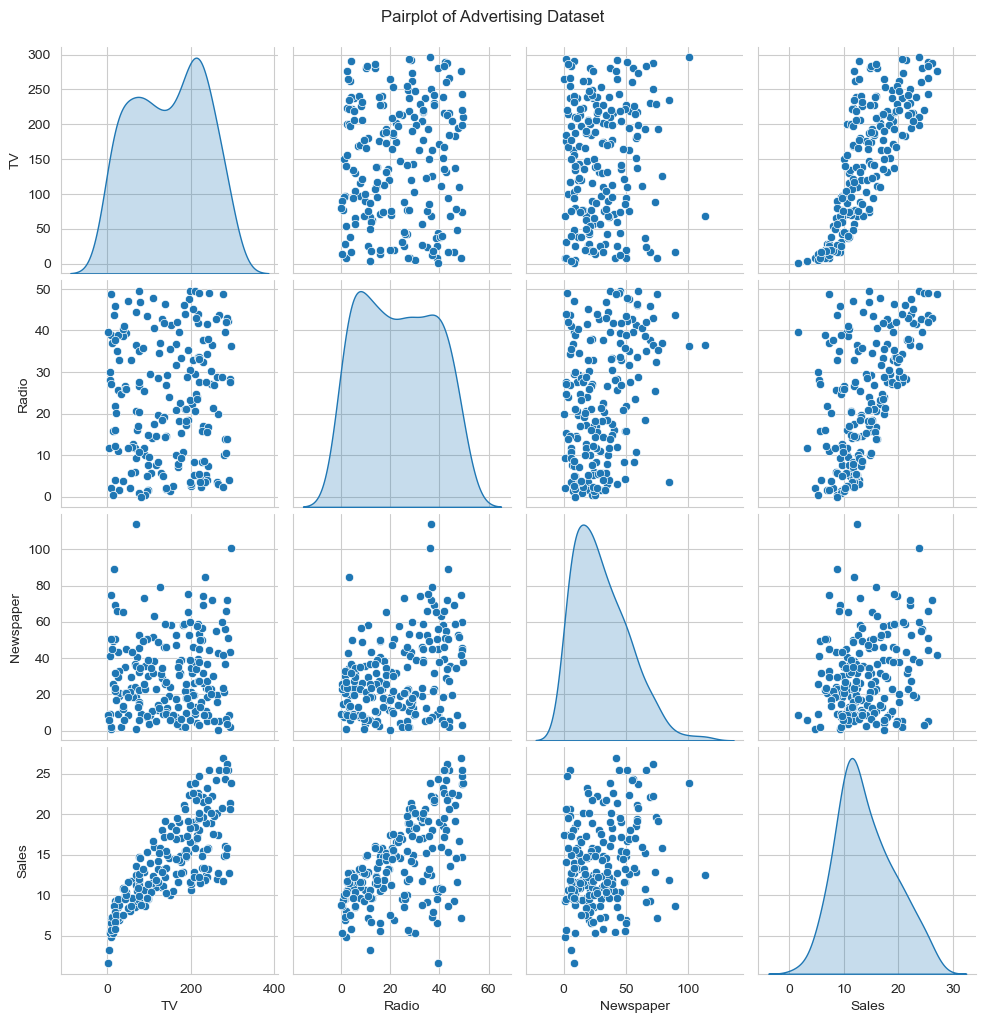

In [9]:
sns.pairplot(df, diag_kind='kde')
plt.suptitle('Pairplot of Advertising Dataset', y=1.02)
plt.show()

## Data Preprocessing

Now let's prepare our data for machine learning. We'll split the data into features and target, then create training and testing sets.

In [10]:

X = df[['TV', 'Radio', 'Newspaper']]
y = df['Sales']

print("Features shape:", X.shape)
print("Target shape:", y.shape)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

print("\nTraining set size:", X_train.shape[0])
print("Testing set size:", X_test.shape[0])

Features shape: (200, 3)
Target shape: (200,)

Training set size: 160
Testing set size: 40


In [11]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

print("Feature scaling completed!")
print("\nScaled training data mean:", X_train_scaled.mean(axis=0))
print("Scaled training data std:", X_train_scaled.std(axis=0))

Feature scaling completed!

Scaled training data mean: [-2.94209102e-16 -2.08166817e-16  1.66533454e-17]
Scaled training data std: [1. 1. 1.]


## Training and Evaluating Models

Let's train multiple regression models and evaluate their performance.

In [12]:
models = {
    'Linear Regression': LinearRegression(),
    'Ridge Regression': Ridge(alpha=1.0),
    'Lasso Regression': Lasso(alpha=0.1),
    'Decision Tree': DecisionTreeRegressor(random_state=42),
    'Random Forest': RandomForestRegressor(n_estimators=100, random_state=42),
    'Gradient Boosting': GradientBoostingRegressor(n_estimators=100, random_state=42),
    'Support Vector Regressor': SVR(kernel='rbf')
}
results = {}

print("Training models...\n")
print("="*80)

for name, model in models.items():
    if name in ['Ridge Regression', 'Lasso Regression', 'Support Vector Regressor']:
        model.fit(X_train_scaled, y_train)
        y_pred = model.predict(X_test_scaled)
    else:
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
    mse = mean_squared_error(y_test, y_pred)
    rmse = np.sqrt(mse)
    mae = mean_absolute_error(y_test, y_pred)
    r2 = r2_score(y_test, y_pred)
    results[name] = {
        'MSE': mse,
        'RMSE': rmse,
        'MAE': mae,
        'R2': r2,
        'predictions': y_pred
    }
    print(f"{name}:")
    print(f"  MSE:  {mse:.4f}")
    print(f"  RMSE: {rmse:.4f}")
    print(f"  MAE:  {mae:.4f}")
    print(f"  R² Score: {r2:.4f}")
    print("-"*80)

Training models...

Linear Regression:
  MSE:  3.1741
  RMSE: 1.7816
  MAE:  1.4608
  R² Score: 0.8994
--------------------------------------------------------------------------------
Ridge Regression:
  MSE:  3.1942
  RMSE: 1.7872
  MAE:  1.4643
  R² Score: 0.8988
--------------------------------------------------------------------------------
Lasso Regression:
  MSE:  3.2089
  RMSE: 1.7913
  MAE:  1.4613
  R² Score: 0.8983
--------------------------------------------------------------------------------
Decision Tree:
  MSE:  2.1750
  RMSE: 1.4748
  MAE:  0.9850
  R² Score: 0.9311
--------------------------------------------------------------------------------
Random Forest:
  MSE:  0.5907
  RMSE: 0.7686
  MAE:  0.6201
  R² Score: 0.9813
--------------------------------------------------------------------------------
Gradient Boosting:
  MSE:  0.5326
  RMSE: 0.7298
  MAE:  0.6187
  R² Score: 0.9831
--------------------------------------------------------------------------------
Suppor

## Comparing Model Performance

Let's visualize the performance of all models to see which one performs best.

In [13]:
comparison_df = pd.DataFrame({
    'Model': list(results.keys()),
    'RMSE': [results[model]['RMSE'] for model in results.keys()],
    'MAE': [results[model]['MAE'] for model in results.keys()],
    'R² Score': [results[model]['R2'] for model in results.keys()]
})
comparison_df = comparison_df.sort_values('R² Score', ascending=False)

print("Model Performance Comparison:")
print("="*80)
print(comparison_df.to_string(index=False))
print("\n" + "="*80)
print(f"Best performing model: {comparison_df.iloc[0]['Model']}")
print(f"R² Score: {comparison_df.iloc[0]['R² Score']:.4f}")

Model Performance Comparison:
                   Model     RMSE      MAE  R² Score
       Gradient Boosting 0.729782 0.618742  0.983127
           Random Forest 0.768591 0.620100  0.981284
           Decision Tree 1.474788 0.985000  0.931091
Support Vector Regressor 1.691777 1.162139  0.909322
       Linear Regression 1.781600 1.460757  0.899438
        Ridge Regression 1.787220 1.464301  0.898803
        Lasso Regression 1.791334 1.461273  0.898336

Best performing model: Gradient Boosting
R² Score: 0.9831


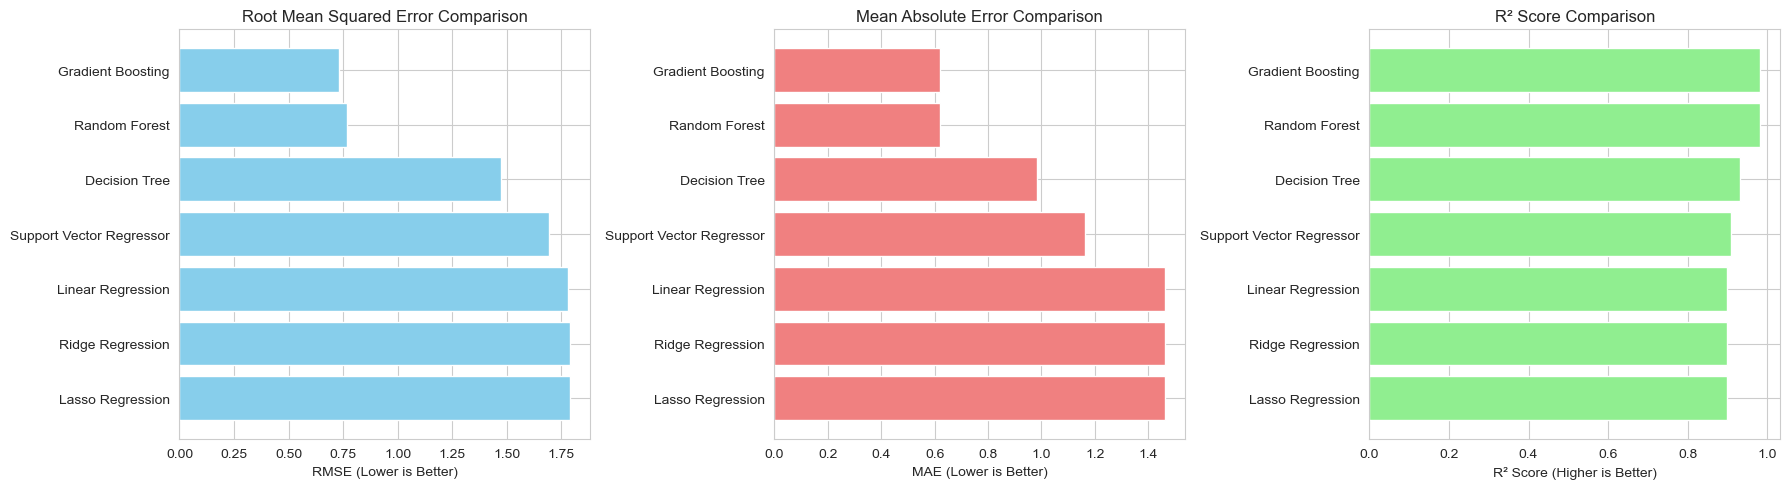

In [14]:
fig, axes = plt.subplots(1, 3, figsize=(18, 5))
axes[0].barh(comparison_df['Model'], comparison_df['RMSE'], color='skyblue')
axes[0].set_xlabel('RMSE (Lower is Better)')
axes[0].set_title('Root Mean Squared Error Comparison')
axes[0].invert_yaxis()
axes[1].barh(comparison_df['Model'], comparison_df['MAE'], color='lightcoral')
axes[1].set_xlabel('MAE (Lower is Better)')
axes[1].set_title('Mean Absolute Error Comparison')
axes[1].invert_yaxis()
axes[2].barh(comparison_df['Model'], comparison_df['R² Score'], color='lightgreen')
axes[2].set_xlabel('R² Score (Higher is Better)')
axes[2].set_title('R² Score Comparison')
axes[2].invert_yaxis()

plt.tight_layout()
plt.show()

## Detailed Model Analysis

Let's take a closer look at the predictions from our best models.

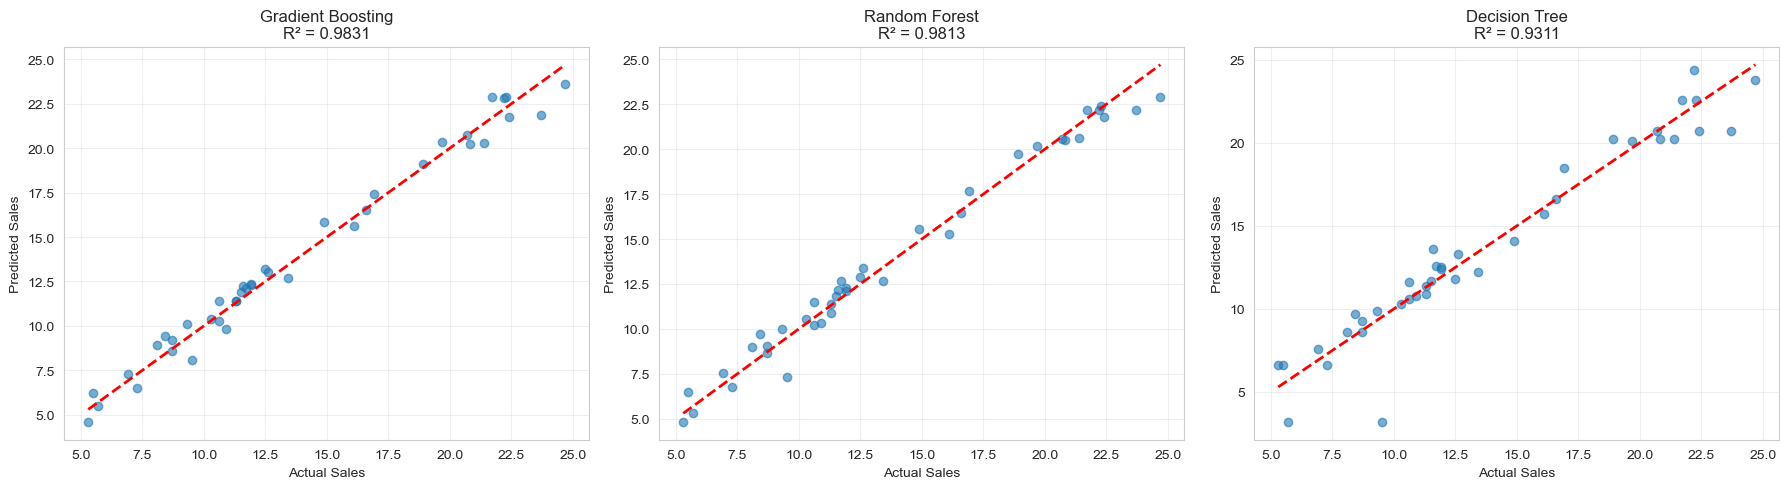

In [15]:
top_3_models = comparison_df.head(3)['Model'].tolist()

fig, axes = plt.subplots(1, 3, figsize=(18, 5))

for idx, model_name in enumerate(top_3_models):
    y_pred = results[model_name]['predictions']
    
    axes[idx].scatter(y_test, y_pred, alpha=0.6)
    axes[idx].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 'r--', lw=2)
    axes[idx].set_xlabel('Actual Sales')
    axes[idx].set_ylabel('Predicted Sales')
    axes[idx].set_title(f'{model_name}\nR² = {results[model_name]["R2"]:.4f}')
    axes[idx].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

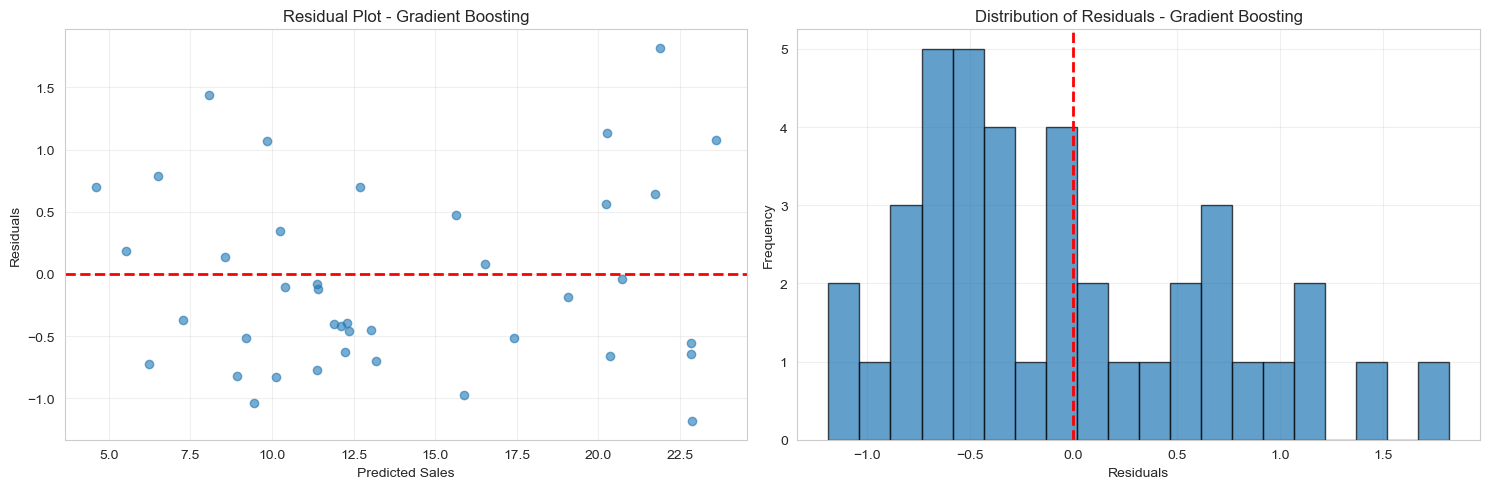

Residual Statistics for Gradient Boosting:
Mean of Residuals: -0.0607
Std of Residuals: 0.7365


In [16]:
best_model_name = comparison_df.iloc[0]['Model']
best_predictions = results[best_model_name]['predictions']
residuals = y_test - best_predictions

fig, axes = plt.subplots(1, 2, figsize=(15, 5))

axes[0].scatter(best_predictions, residuals, alpha=0.6)
axes[0].axhline(y=0, color='r', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Sales')
axes[0].set_ylabel('Residuals')
axes[0].set_title(f'Residual Plot - {best_model_name}')
axes[0].grid(True, alpha=0.3)


axes[1].hist(residuals, bins=20, edgecolor='black', alpha=0.7)
axes[1].set_xlabel('Residuals')
axes[1].set_ylabel('Frequency')
axes[1].set_title(f'Distribution of Residuals - {best_model_name}')
axes[1].axvline(x=0, color='r', linestyle='--', linewidth=2)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Residual Statistics for {best_model_name}:")
print(f"Mean of Residuals: {residuals.mean():.4f}")
print(f"Std of Residuals: {residuals.std():.4f}")

## Feature Importance Analysis

For tree-based models, let's analyze which advertising channels have the most impact on sales.

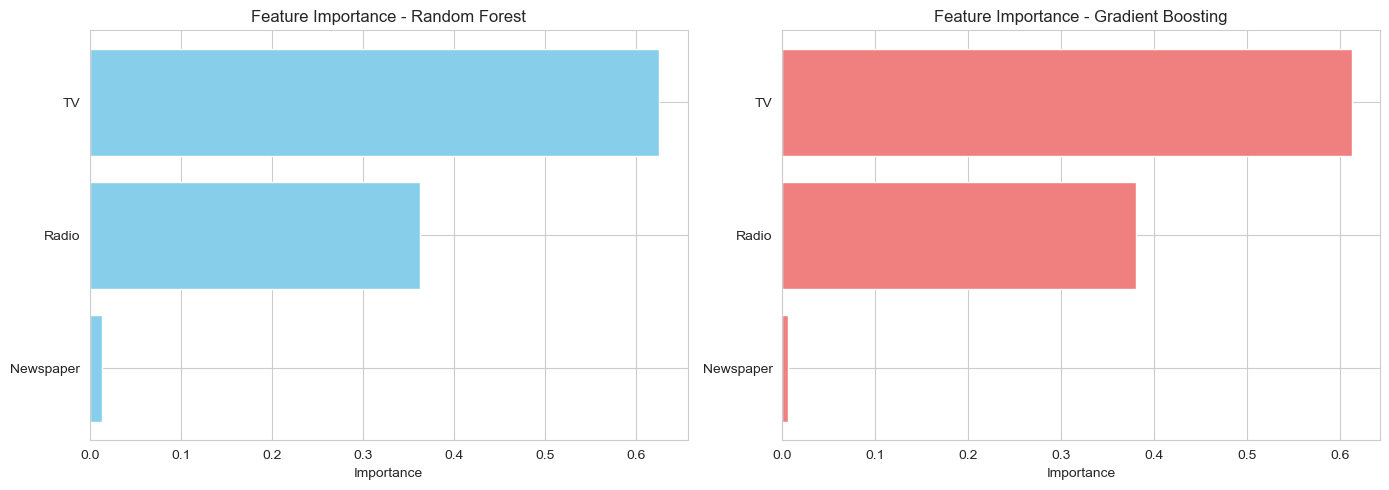

Feature Importance:
  Feature  Random Forest  Gradient Boosting
       TV       0.624810           0.612579
    Radio       0.362201           0.380914
Newspaper       0.012989           0.006507


In [17]:
rf_model = RandomForestRegressor(n_estimators=100, random_state=42)
gb_model = GradientBoostingRegressor(n_estimators=100, random_state=42)

rf_model.fit(X_train, y_train)
gb_model.fit(X_train, y_train)

rf_importance = rf_model.feature_importances_
gb_importance = gb_model.feature_importances_

feature_names = ['TV', 'Radio', 'Newspaper']
importance_df = pd.DataFrame({
    'Feature': feature_names,
    'Random Forest': rf_importance,
    'Gradient Boosting': gb_importance
})

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

axes[0].barh(importance_df['Feature'], importance_df['Random Forest'], color='skyblue')
axes[0].set_xlabel('Importance')
axes[0].set_title('Feature Importance - Random Forest')
axes[0].invert_yaxis()

axes[1].barh(importance_df['Feature'], importance_df['Gradient Boosting'], color='lightcoral')
axes[1].set_xlabel('Importance')
axes[1].set_title('Feature Importance - Gradient Boosting')
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()

print("Feature Importance:")
print(importance_df.to_string(index=False))

## Making Predictions

using our best model to make predictions.

In [18]:

best_model_name = comparison_df.iloc[0]['Model']
final_model = models[best_model_name]

if best_model_name in ['Ridge Regression', 'Lasso Regression', 'Support Vector Regressor']:
    X_scaled = scaler.fit_transform(X)
    final_model.fit(X_scaled, y)
else:
    final_model.fit(X, y)

print(f"Final model trained: {best_model_name}")
print("\nYou can now use this model to predict sales based on advertising budgets!")

Final model trained: Gradient Boosting

You can now use this model to predict sales based on advertising budgets!


In [19]:

sample_budgets = pd.DataFrame({
    'TV': [150.0, 200.0, 50.0, 300.0],
    'Radio': [30.0, 40.0, 10.0, 50.0],
    'Newspaper': [40.0, 30.0, 20.0, 60.0]
})

if best_model_name in ['Ridge Regression', 'Lasso Regression', 'Support Vector Regressor']:
    sample_budgets_scaled = scaler.transform(sample_budgets)
    predicted_sales = final_model.predict(sample_budgets_scaled)
else:
    predicted_sales = final_model.predict(sample_budgets)

sample_budgets['Predicted_Sales'] = predicted_sales

print("Sample Predictions:")
print("="*80)
print(sample_budgets.to_string(index=False))
print("\n" + "="*80)

Sample Predictions:
   TV  Radio  Newspaper  Predicted_Sales
150.0   30.0       40.0        16.133217
200.0   40.0       30.0        21.120339
 50.0   10.0       20.0         8.567441
300.0   50.0       60.0        27.115360



## Conclusion

### Key Findings:

I tried out seven regression models to predict sales, and ensemble models like Random Forest and Gradient Boosting gave the best results.
TV ads had the biggest impact on sales, followed by Radio, while Newspaper didn’t contribute much.

In short:
Spend more on TV and Radio for better results, keep updating the model with new data, and test different ad budget combinations to see what works best.

Next, you can fine-tune the model, add more features, and maybe even deploy it for real-time predictions